## 1) download data

In [1]:
!unzip brown.zip -d brown

Archive:  brown.zip
   creating: brown/brown/
  inflating: brown/__MACOSX/._brown  
  inflating: brown/brown/cd05        
  inflating: brown/__MACOSX/brown/._cd05  
  inflating: brown/brown/cf37        
  inflating: brown/__MACOSX/brown/._cf37  
  inflating: brown/brown/cj50        
  inflating: brown/__MACOSX/brown/._cj50  
  inflating: brown/brown/cf08        
  inflating: brown/__MACOSX/brown/._cf08  
  inflating: brown/brown/cl06        
  inflating: brown/__MACOSX/brown/._cl06  
  inflating: brown/brown/cj68        
  inflating: brown/__MACOSX/brown/._cj68  
  inflating: brown/brown/cf30        
  inflating: brown/__MACOSX/brown/._cf30  
  inflating: brown/brown/cd02        
  inflating: brown/__MACOSX/brown/._cd02  
  inflating: brown/brown/cl01        
  inflating: brown/__MACOSX/brown/._cl01  
  inflating: brown/brown/cj57        
  inflating: brown/__MACOSX/brown/._cj57  
  inflating: brown/brown/cf06        
  inflating: brown/__MACOSX/brown/._cf06  
  inflating: brown/brown/

In [2]:
import random
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# first version 20k missing
import os

# read in the single brown corpus files and combine to one file
def load_brown_words(dataset_path):
    all_words = []
    # The Brown corpus files are often in a subfolder named 'brown'
    brown_dir = os.path.join(dataset_path, 'brown') if 'brown' not in dataset_path else dataset_path

    # Files are usually named like 'ca01', 'cb01' etc.
    for filename in sorted(os.listdir(brown_dir)):
        # Skip non-data files
        if filename.startswith('.') or filename.endswith('.zip') or filename == 'README':
            continue

        file_path = os.path.join(brown_dir, filename)
        with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
            # The Brown corpus often has 'word/tag' format.
            # We only want the words.
            for line in f:
                for tagged_word in line.strip().split():
                    if '/' in tagged_word:
                        word = tagged_word.rsplit('/', 1)[0]
                        all_words.append(word)
                    else:
                        all_words.append(tagged_word)
    return all_words

# create np.array to increase flexibility for following operations

In [4]:
from collections import defaultdict, Counter
import math

# since we right now only got individual words after each other in our data, we need to construct individual sentences first and add padding
def reconstruct_sentences(flat_list):
    sentences = []
    current_sentence = []

    # sign of end of sentence can be ".", "!" or "?"
    sentence_enders = {'.', '!', '?'}

    for word in flat_list:
        current_sentence.append(word)
        if word in sentence_enders:
            sentences.append(current_sentence)
            current_sentence = []

    return sentences

def replace_rare_words(sentences, min_freq=3):
    counts = Counter(word for sent in sentences for word in sent)
    keep_words = {word for word, count in counts.items() if count >= min_freq}

    processed_sentences = [
        [word if word in keep_words else '<UNK>' for word in sent]
        for sent in sentences
    ]

    return processed_sentences

def build_vocab(train_sentences):
    # Da <UNK> schon im Text ist, nehmen wir einfach alle unique tokens
    vocab = set(word for sent in train_sentences for word in sent)
    vocab.add('<s>')
    vocab.add('</s>')
    return vocab, len(vocab)

In [ ]:
################ PREP DATA ################
brown_data = np.array(load_brown_words("./brown"))
print(f"brown data shape{brown_data.shape}")

# split data
train_words = brown_data[:800000]
val_words = brown_data[800000:1000000]
test_words = brown_data[1000000:]

# recreate sentences for every set
train_sents = reconstruct_sentences(train_words)
val_sents = reconstruct_sentences(val_words)
test_sents = reconstruct_sentences(test_words)

# substitute words that occur less often then 3 times
train_sents_clean = replace_rare_words(train_sents)

# substitute words that occur less often then 3 times
train_sents = replace_rare_words(train_sents)

# create vocabulary only based on train data to prevent test set leakage
V, V_size = build_vocab(train_sents)
print(V_size)

# substitute words (with <UNK>) that do occur val/ test set but not in the train vocab
val_sents_clean = []
test_sents_clean = []

print("Processing validation and test sets...")

# Transform validation set: Map OOV words to <UNK> based on training vocab V
for sent in val_sents:
    # Use training vocabulary V to determine UNK substitution
    safe_sent = [w if w in V else '<UNK>' for w in sent]
    val_sents_clean.append(safe_sent)

# Transform test set: Map OOV words to <UNK> based on training vocab V
for sent in test_sents:
    # Ensure consistency with Bengio's frequency <= 3 threshold
    safe_sent = [w if w in V else '<UNK>' for w in sent]
    test_sents_clean.append(safe_sent)

print(f"Train set: {len(train_sents)}")
print(f"Val set: {len(val_sents)}")
print(f"Test set: {len(test_sents)}")
print(f"V size: {V_size}")

print("===================")

################ CREATE WORD/INDEX MAPPINGS ################
sorted_vocab = sorted(list(V))
word_to_idx = {word: i for i, word in enumerate(sorted_vocab)}
idx_to_word = {i: word for i, word in enumerate(sorted_vocab)}
print(word_to_idx)
print(idx_to_word)

brown data shape(1161192,)
17714
Processing validation and test sets...
Train set: 33035
Val set: 11851
Test set: 10749
V size: 17714
{np.str_('!'): 0, np.str_('$.03'): 1, np.str_('$.07'): 2, np.str_('$1'): 3, np.str_('$1,000'): 4, np.str_('$1,500'): 5, np.str_('$1.1'): 6, np.str_('$10'): 7, np.str_('$10,000'): 8, np.str_('$100'): 9, np.str_('$100,000'): 10, np.str_('$135'): 11, np.str_('$14'): 12, np.str_('$15'): 13, np.str_('$15,000'): 14, np.str_('$150'): 15, np.str_('$17,000'): 16, np.str_('$2'): 17, np.str_('$2,000'): 18, np.str_('$20'): 19, np.str_('$20,000'): 20, np.str_('$200'): 21, np.str_('$25'): 22, np.str_('$25,000'): 23, np.str_('$250'): 24, np.str_('$28'): 25, np.str_('$3'): 26, np.str_('$3,000'): 27, np.str_('$30,000'): 28, np.str_('$300'): 29, np.str_('$37'): 30, np.str_('$4'): 31, np.str_('$40'): 32, np.str_('$400'): 33, np.str_('$45'): 34, np.str_('$450'): 35, np.str_('$5'): 36, np.str_('$5,000'): 37, np.str_('$5,000,000'): 38, np.str_('$50'): 39, np.str_('$500'): 40,

In [8]:
import random
################ JUST FOR TESTING: SHUFFLING ################

################ PREP DATA ################
# 1. Load the flat list of words
brown_data = np.array(load_brown_words("./brown"))

# 2. Reconstruct ALL sentences first
all_sents = reconstruct_sentences(brown_data)
print(f"Total sentences: {len(all_sents)}")

# 3. SHUFFLE the sentences
# Use a seed for reproducibility so your splits stay the same every time you run it
random.seed(42)
random.shuffle(all_sents)

# 4. SPLIT the shuffled sentences (Bengio used roughly 80/10/10)
num_sents = len(all_sents)
train_end = int(num_sents * 0.8)
val_end = int(num_sents * 0.9)

train_sents = all_sents[:train_end]
val_sents = all_sents[train_end:val_end]
test_sents = all_sents[val_end:]

################ VOCAB & CLEANING ################

# 5. Build Vocabulary ONLY based on train_sents
# replace_rare_words will handle the <UNK> mapping for the training set
train_sents_clean = replace_rare_words(train_sents, min_freq=3)

# Create vocabulary set from the cleaned training data
V = set(word for sent in train_sents_clean for word in sent)
V.update(['<s>', '</s>'])
V_size = len(V)

# 6. Transform validation and test sets
# Any word not in V (from training) must become <UNK>
def clean_eval_set(sentences, vocab):
    cleaned = []
    for sent in sentences:
        safe_sent = [w if w in vocab else '<UNK>' for w in sent]
        cleaned.append(safe_sent)
    return cleaned

val_sents_clean = clean_eval_set(val_sents, V)
test_sents_clean = clean_eval_set(test_sents, V)

print(f"Train sentences: {len(train_sents_clean)}")
print(f"Val sentences: {len(val_sents_clean)}")
print(f"Test sentences: {len(test_sents_clean)}")
print(f"Vocabulary size: {V_size}")

################ CREATE WORD/INDEX MAPPINGS ################
sorted_vocab = sorted(list(V))
word_to_idx = {word: i for i, word in enumerate(sorted_vocab)}
idx_to_word = {i: word for i, word in enumerate(sorted_vocab)}
print(word_to_idx)
print(idx_to_word)

Total sentences: 55635
Train sentences: 44508
Val sentences: 5563
Test sentences: 5564
Vocabulary size: 19518
{'!': 0, '$.03': 1, '$1': 2, '$1,000': 3, '$1,500': 4, '$1.1': 5, '$10': 6, '$10,000': 7, '$100': 8, '$125': 9, '$135': 10, '$15': 11, '$15,000': 12, '$150': 13, '$17,000': 14, '$2': 15, '$2,000': 16, '$20': 17, '$20,000': 18, '$200': 19, '$25': 20, '$25,000': 21, '$250': 22, '$3,000': 23, '$30,000': 24, '$300': 25, '$37': 26, '$4': 27, '$40': 28, '$45': 29, '$450': 30, '$5': 31, '$5,000': 32, '$50': 33, '$500': 34, '$500,000': 35, '$5000': 36, '$60': 37, '$600': 38, '$7': 39, '$700': 40, '$75': 41, '$750': 42, '$800': 43, '&': 44, "'": 45, "''": 46, "'48": 47, "'50": 48, "'52": 49, "'58": 50, "'em": 51, "'im": 52, "'round": 53, '(': 54, ')': 55, '**ya': 56, '**yb': 57, '**yc': 58, '**yf': 59, '**yl': 60, '**yt': 61, '**zg': 62, ',': 63, '-': 64, '--': 65, '-78-degrees': 66, '.': 67, '/': 68, '0': 69, '0.1': 70, '0.2': 71, '0.3': 72, '0.4': 73, '0.5': 74, '05': 75, '1': 76, '1,

In [9]:
################ CREATE FINAL DATASETS ################
def create_mlp_dataset(sentences, word_to_idx, context_size=5):
    """
    Converts a list of sentences into context-target pairs for the MLP.
    X: Matrix of context word indices.
    y: Vector of target word indices.
    """

    X = []
    y = []

    for sent in sentences:
        # Add padding as defined in the paper (2 start tokens, 1 end token)
        # Note: We use the same context as the Trigram baseline
        tokens = ['<s>'] * context_size + sent + ['</s>']

        # Sliding window over the tokens
        for i in range(context_size, len(tokens)):
            # Get indices for the context (previous n-1 words)
            context = [word_to_idx[tokens[j]] for j in range(i - context_size, i)]
            # Get index for the current target word
            target = word_to_idx[tokens[i]]

            X.append(context)
            y.append(target)

    return np.array(X), np.array(y)

# Generate numerical datasets for training, validation, and testing
# Using the cleaned sentences where OOV words are already <UNK>
X_train, y_train = create_mlp_dataset(train_sents_clean, word_to_idx)
X_val, y_val = create_mlp_dataset(val_sents_clean, word_to_idx)
X_test, y_test = create_mlp_dataset(test_sents_clean, word_to_idx)

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_val, y_val = torch.tensor(X_val), torch.tensor(y_val)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

print(f"Training samples: {X_train.shape}")
print(f"Vocabulary size: {len(word_to_idx)}")
print(X_train.shape)
print(X_train)
print(y_train)

Training samples: torch.Size([976283, 5])
Vocabulary size: 19518
torch.Size([976283, 5])
tensor([[  430,   430,   430,   430,   430],
        [  430,   430,   430,   430,  3376],
        [  430,   430,   430,  3376, 14155],
        ...,
        [18151,  5435, 10010, 14692,  5409],
        [ 5435, 10010, 14692,  5409,  5476],
        [10010, 14692,  5409,  5476,    67]])
tensor([ 3376, 14155, 19197,  ...,  5476,    67,   428])


## 2) Define & train MLP

In [ ]:
# define network
g = torch.Generator().manual_seed(2147483647)

# create parameter tensors
C = torch.randn((len(word_to_idx),30), generator=g)
W1 = torch.randn((150,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,len(word_to_idx)), generator=g)
b2 = torch.randn(len(word_to_idx), generator=g)

#W_direct = torch.randn((300, len(word_to_idx)), generator=g).to(device) * 0.001

# override tensors with kaiming init
torch.nn.init.xavier_normal_(W1)
torch.nn.init.xavier_normal_(W2)

torch.nn.init.normal_(C, mean=0, std=0.1)

# biases to 0
with torch.no_grad():
    b1.fill_(0)
    b2.fill_(0)

C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
# trainingn OLD
lossh_outer = []
lr_history = []
epochs = 20
batch_size = 32
context_size = 5
embedding_dims = 30
epsilon_0 = 0.1  # Initial learning rate
r = 10**-8 * batch_size          # lr decrease factor
weight_decay = 0  # weight decay determined by bengio et al.
t = 0

for epoch in range(epochs):
    # X_train / batch_size equals the amount of iterations needed to loop once over the whole training data
    # we do this 10 times (10 epochs)
    lossh_inner = []
    for k in range(len(X_train)//batch_size):

        t += 1
        lr_t = epsilon_0 / (1+r*t)
        lr_history.append(lr_t)

        # batch selection
        start = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
        X_batch, y_batch = X_train[start], y_train[start]
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # forward pass
        emb = C[X_batch]
        h = torch.tanh(emb.view(-1,context_size * embedding_dims) @ W1 + b1)
        logits = (h @ W2 + b2) # + (emb.view(-1, context_size * embedding_dims) @ W_direct)

        # calculate loss (negative log likelihood)
        loss = F.cross_entropy(logits, y_batch)
        lossh_inner.append(loss.item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        C.data += -lr_t * (C.grad + weight_decay * C.data)
        W1.data += -lr_t * (W1.grad + weight_decay * W1.data)
        b1.data += -lr_t * b1.grad
        W2.data += -lr_t * (W2.grad + weight_decay * W2.data)
        b2.data += -lr_t * b2.grad

        '''
        # update
        with torch.no_grad():
            for p in parameters:
                # + weight decay
                p.data += -lr_t * p.grad
        '''

        # print loss and perplexity every 1000 iterations
        #if k % 1000 == 0:
        #    print(f"Epoch {epoch}, Iteration{k}: Loss: {sum(lossh_inner)/len(lossh_inner):.4f} / Perplexity: {np.exp(sum(lossh_inner)/len(lossh_inner))}")

    lossh_outer.append(sum(lossh_inner)/len(lossh_inner))
    print("==========================")
    print(f"Iteration {epoch}: Loss {sum(lossh_inner)/len(lossh_inner):.4f}")
    print(f"This resembles a perplexity of: {np.exp(sum(lossh_inner)/len(lossh_inner))}")

Epoch 0, Iteration0: Loss: 9.7803 / Perplexity: 17682.599925765047
Epoch 0, Iteration1000: Loss: 7.7836 / Perplexity: 2400.85173773231
Epoch 0, Iteration2000: Loss: 7.1742 / Perplexity: 1305.3336216096748
Epoch 0, Iteration3000: Loss: 6.9213 / Perplexity: 1013.6373672143931
Epoch 0, Iteration4000: Loss: 6.7744 / Perplexity: 875.1607170526868
Epoch 0, Iteration5000: Loss: 6.6606 / Perplexity: 781.041520987465
Epoch 0, Iteration6000: Loss: 6.5740 / Perplexity: 716.2147439973356
Epoch 0, Iteration7000: Loss: 6.5133 / Perplexity: 674.0704769296631
Epoch 0, Iteration8000: Loss: 6.4601 / Perplexity: 639.0968719399723
Epoch 0, Iteration9000: Loss: 6.4135 / Perplexity: 610.0404340187773
Epoch 0, Iteration10000: Loss: 6.3779 / Perplexity: 588.6769382136879
Epoch 0, Iteration11000: Loss: 6.3405 / Perplexity: 567.0879713471845
Epoch 0, Iteration12000: Loss: 6.3102 / Perplexity: 550.1348582344234
Epoch 0, Iteration13000: Loss: 6.2869 / Perplexity: 537.4637990133701
Epoch 0, Iteration14000: Loss: 6

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(torch.arange(0,10), lossh_outer)
plt.show()

In [ ]:
# doch nochmal andere/ größere architektur testen?

## LR range test

Text(0.5, 1.0, 'LR range testing')

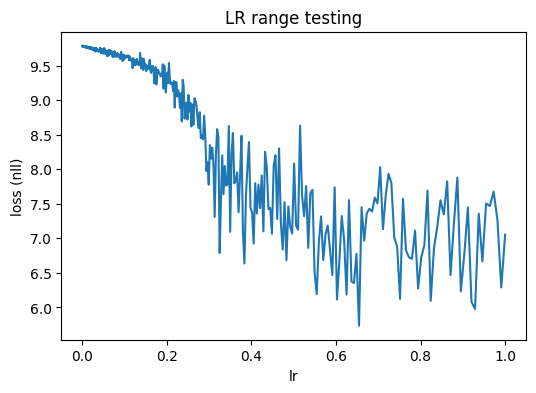

In [15]:
lre = torch.linspace(-4, 0, 1000)
lrs = 10**lre

lri = []
lossi = []

context_size = 5
embedding_dims = 30


for k in range(1000):

    for batch in range(1):

        # batch selection
        start = torch.randint(0, X_train.shape[0], (32,), generator=g)
        X_batch, y_batch = X_train[start], y_train[start]
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        emb = C[X_batch]
        h = torch.tanh(emb.view(-1,context_size * embedding_dims) @ W1 + b1)
        logits = (h @ W2 + b2) # + (emb.view(-1, context_size * embedding_dims) @ W_direct)

        # calculate loss (negative log likelihood)
        loss = F.cross_entropy(logits, y_batch)

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = lrs[k]
        with torch.no_grad():
            for p in parameters:
                p.data += -lr * p.grad

        # track stats
        lri.append(lr)
        lossi.append(loss.item())

plt.figure(figsize=(6,4))
plt.plot(lri, lossi)
plt.xlabel("lr")
plt.ylabel("loss (nll)")
plt.title("LR range testing")

## New approach with validation

In [ ]:
def evaluate(X, y):
    # Switch to evaluation mode (not strictly necessary for raw tensors but good practice)
    model_loss = []

    # Disable gradient tracking for speed and memory efficiency
    with torch.no_grad():
        # Process in larger batches to speed up evaluation
        eval_batch_size = 1024
        for i in range(0, X.shape[0], eval_batch_size):
            X_batch = X[i:i+eval_batch_size].to(device)
            y_batch = y[i:i+eval_batch_size].to(device)

            # 1. Forward Pass
            emb = C[X_batch]
            h = torch.tanh(emb.view(-1,context_size * embedding_dims) @ W1 + b1)
            # Using the architecture including Direct Connections if applicable
            logits = h @ W2 + b2

            # 2. Calculate Loss
            loss = F.cross_entropy(logits, y_batch)
            model_loss.append(loss.item())

    avg_loss = sum(model_loss) / len(model_loss)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

# training
history = {
    'train_loss': [],
    'val_loss': [],
    'train_pp': [],
    'val_pp': [],
    'lr': []
}

epochs = 20
batch_size = 32
context_size = 5
embedding_dims = 30
epsilon_0 = 0.1  # Initial learning rate; adapted based on lr overview above
r = 10**-8 * batch_size          # lr decrease factor; sclaed by batch_size to make up for not using SGD
weight_decay = 10**-4  # weight decay determined by bengio et al.
t = 0

for epoch in range(epochs):
    epoch_losses = []
    epoch_lr = []

    for k in range(len(X_train)//batch_size):
        t += 1
        lr_t = epsilon_0 / (1+r*t)

        # batch selection
        start = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
        X_batch, y_batch = X_train[start], y_train[start]
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # forward pass
        emb = C[X_batch]
        h = torch.tanh(emb.view(-1,context_size * embedding_dims) @ W1 + b1)
        logits = (h @ W2 + b2) # + (emb.view(-1, context_size * embedding_dims) @ W_direct)

        # calculate loss (negative log likelihood)
        loss = F.cross_entropy(logits, y_batch)
        epoch_losses.append(loss.item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        with torch.no_grad():
            C.data += -lr_t * (C.grad + weight_decay * C.data)
            W1.data += -lr_t * (W1.grad + weight_decay * W1.data)
            b1.data += -lr_t * b1.grad
            W2.data += -lr_t * (W2.grad + weight_decay * W2.data)
            b2.data += -lr_t * b2.grad

    # track train progress
    avg_train_loss = np.mean(epoch_losses)
    history['train_loss'].append(avg_train_loss)
    history['train_pp'].append(np.exp(avg_train_loss))
    history['lr'].append(lr_t)

    # compute and track val loss and perplexity
    avg_val_loss, val_pp = evaluate(X_val, y_val)
    history['val_loss'].append(avg_val_loss)
    history['val_pp'].append(val_pp)

    # print train progress
    print(f"Epoch {epoch}: Train Loss {avg_train_loss:.4f} | Train PP {np.exp(avg_train_loss)} | Val Loss {avg_val_loss:.4f} | Val PP {val_pp:.2f}")
    print("==========================")

Epoch 0: Train Loss 6.0012 | Train PP 403.8993216731266 | Val Loss 5.6179 | Val PP 275.32
Epoch 1: Train Loss 5.6079 | Train PP 272.58138770220273 | Val Loss 5.4717 | Val PP 237.86
Epoch 2: Train Loss 5.4842 | Train PP 240.84424802369287 | Val Loss 5.4062 | Val PP 222.77
Epoch 3: Train Loss 5.4039 | Train PP 222.2718357818179 | Val Loss 5.3666 | Val PP 214.12
Epoch 4: Train Loss 5.3562 | Train PP 211.91168782472946 | Val Loss 5.3267 | Val PP 205.76
Epoch 5: Train Loss 5.3063 | Train PP 201.6004818475581 | Val Loss 5.3180 | Val PP 203.97
Epoch 6: Train Loss 5.2738 | Train PP 195.15752274082547 | Val Loss 5.3065 | Val PP 201.63
Epoch 7: Train Loss 5.2583 | Train PP 192.15336607797803 | Val Loss 5.2825 | Val PP 196.86
Epoch 8: Train Loss 5.2353 | Train PP 187.79480055802955 | Val Loss 5.2738 | Val PP 195.15
Epoch 9: Train Loss 5.2153 | Train PP 184.07321815764845 | Val Loss 5.2652 | Val PP 193.49
Epoch 10: Train Loss 5.2059 | Train PP 182.34357129035234 | Val Loss 5.2546 | Val PP 191.45
E

In [44]:
weights_to_save = {
    'C': C,
    'W1': W1,
    'b1': b1,
    'W2': W2,
    'b2': b2
}

torch.save(weights_to_save, "bengio_model_v4.pth")

In [45]:
torch.save(history, "bengio_history_v4.pth")

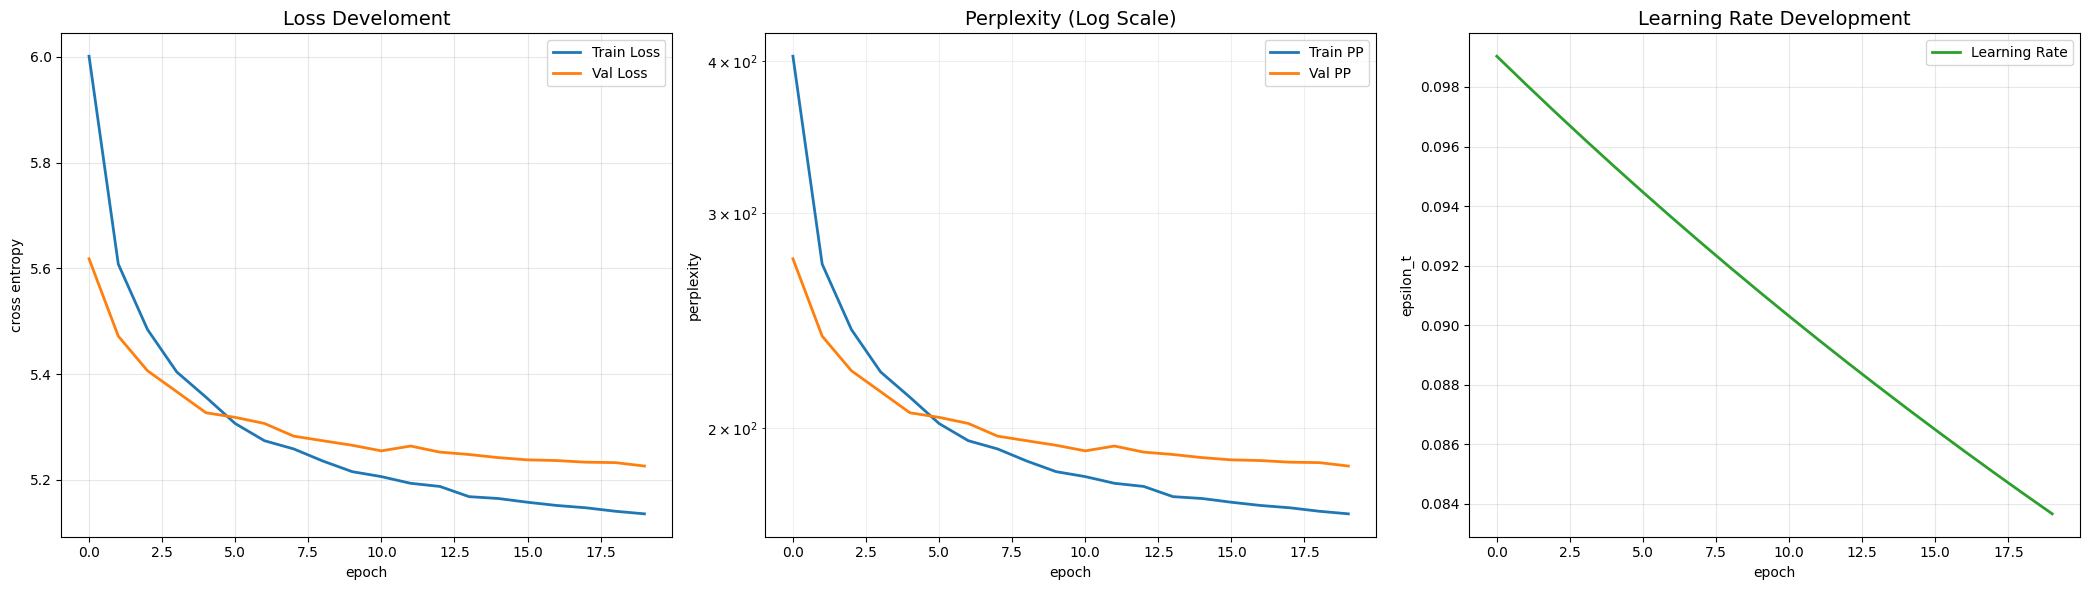

In [46]:
# plot 2 train runs (loss & perplexity each)
# plot 2 lr developments

def plot_training_results(history):
    epochs = range(len(history['train_loss']))

    # Create a figure with 3 subplots
    fig, ax = plt.subplots(1, 3, figsize=(21, 6))

    # 1. Plot Loss (Train vs Val)
    ax[0].plot(epochs, history['train_loss'], label='Train Loss', color='#1f77b4', lw=2)
    ax[0].plot(epochs, history['val_loss'], label='Val Loss', color='#ff7f0e', lw=2)
    ax[0].set_title('Loss Develoment', fontsize=14)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('cross entropy')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # 2. Plot Perplexity (Train vs Val) - Log Scale
    ax[1].plot(epochs, history['train_pp'], label='Train PP', color='#1f77b4', lw=2)
    ax[1].plot(epochs, history['val_pp'], label='Val PP', color='#ff7f0e', lw=2)
    ax[1].set_yscale('log') # Log scale is best practice for Perplexity
    ax[1].set_title('Perplexity (Log Scale)', fontsize=14)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('perplexity')
    ax[1].legend()
    ax[1].grid(True, which="both", ls="-", alpha=0.2)

    # 3. Plot Learning Rate
    ax[2].plot(epochs, history['lr'], label='Learning Rate', color='#2ca02c', lw=2)
    ax[2].set_title('Learning Rate Development', fontsize=14)
    ax[2].set_xlabel('epoch')
    ax[2].set_ylabel('epsilon_t')
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call the function after training
plot_training_results(history)

In [64]:
# reload weights
checkpoint = torch.load('bengio_model_v2.pth', map_location=device)

# 2. Assign the saved values to your variables
C = checkpoint['C']
W1 = checkpoint['W1']
b1 = checkpoint['b1']
W2 = checkpoint['W2']
b2 = checkpoint['b2']
b2

tensor([ 0.8277, -0.1423, -0.1568,  ..., -0.0195, -0.0923, -0.1249],
       requires_grad=True)

In [62]:
# SAMPLING

def sample_next_word_idx(context_indices, temperature=1.0):

    with torch.no_grad():
        x = torch.tensor([context_indices])

        emb = C[x]
        h = torch.tanh(emb.view(-1,context_size * embedding_dims) @ W1 + b1)
        logits = (h @ W2 + b2)

        # temperature scaling = multinomial sampling
        logits = logits / temperature

        probs = F.softmax(logits, dim=1)

        next_word_idx = torch.multinomial(probs, num_samples=1).item()
    return next_word_idx


generated_text = []
context_size = 5
embedding_dims = 30

ix = torch.randint(0, X_val.shape[0], (1,)).item()
context = X_val[ix].tolist()
context = [word_to_idx['<s>']] * 5
print(f"Start sequence is: {[idx_to_word[i] for i in context]}")


for _ in range(20):
    next_word_idx = sample_next_word_idx(context)
    generated_text.append(idx_to_word[next_word_idx])
    context = context[1:] + [next_word_idx]

print(" ".join(generated_text))

Start sequence is: ['<s>', '<s>', '<s>', '<s>', '<s>']
The handy seven tremendous where the allowances of those must was men precedents for marketing and he <UNK> Sunday attitude


In [ ]:
# test accuracy

In [65]:
def evaluate_test(X, y):
    # Switch to evaluation mode (not strictly necessary for raw tensors but good practice)
    model_loss = []

    # Disable gradient tracking for speed and memory efficiency
    with torch.no_grad():
        # Process in larger batches to speed up evaluation
        eval_batch_size = 1024
        for i in range(0, X.shape[0], eval_batch_size):
            X_batch = X[i:i+eval_batch_size].to(device)
            y_batch = y[i:i+eval_batch_size].to(device)

            # 1. Forward Pass
            emb = C[X_batch]
            h = torch.tanh(emb.view(-1,context_size * embedding_dims) @ W1 + b1)
            # Using the architecture including Direct Connections if applicable
            logits = h @ W2 + b2

            # 2. Calculate Loss
            loss = F.cross_entropy(logits, y_batch)
            model_loss.append(loss.item())

    avg_loss = sum(model_loss) / len(model_loss)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity
print(evaluate_test(X_test, y_test))

(4.971920541354588, np.float64(144.303762754496))


In [32]:
# automated hyperparam testing approach

In [ ]:
# pot: improvements of architecture/ overall setup with automated hyperparam testing